In [52]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
dataset=tf.keras.preprocessing.image_dataset_from_directory("Training/Leaf_photos",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 4072 files belonging to 3 classes.


In [4]:
dataset.class_names

['EarlyBlight', 'Healthy', 'LateBlight']

In [5]:
len(dataset) #every dataset in the directory is a batch of 32

128

In [6]:
32*128

4096

In [7]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 0 0 0 2 2 2 0 2 1 0 1 1 1 1 2 0 2 1 0 2 1 1 1 1 2 1 0 2 2 0]


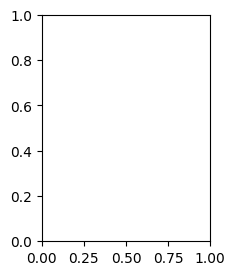

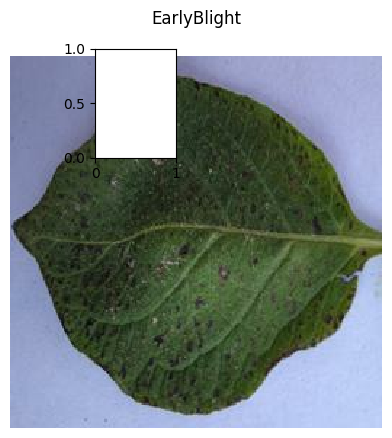

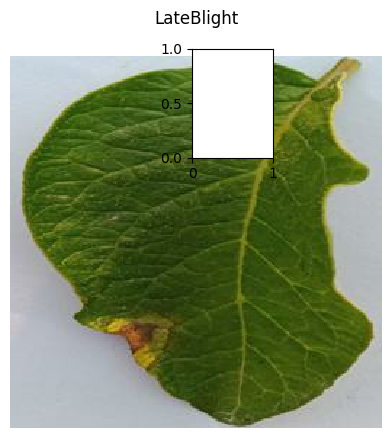

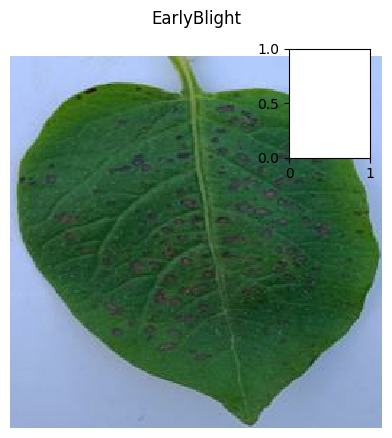

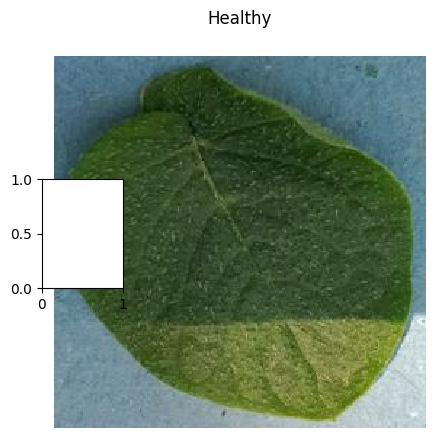

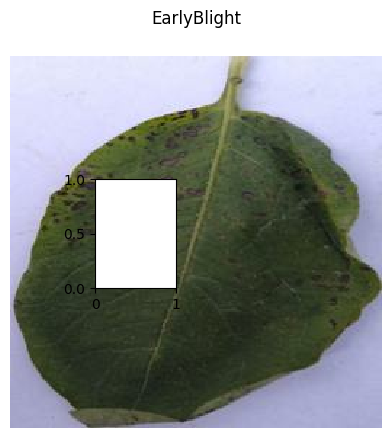

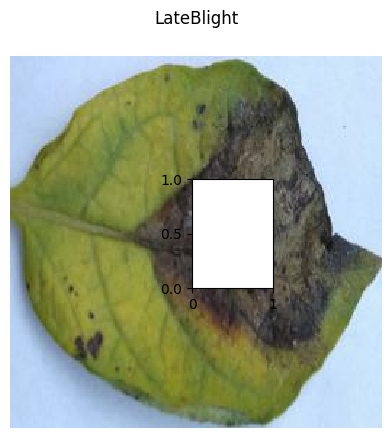

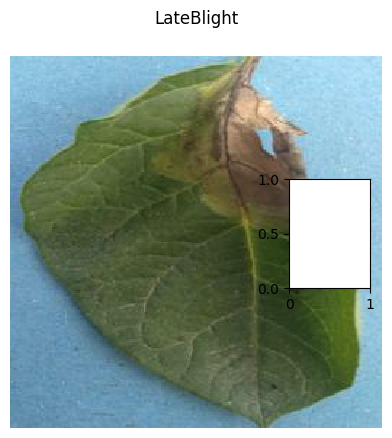

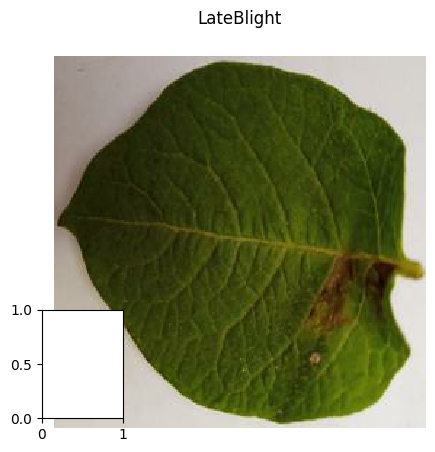

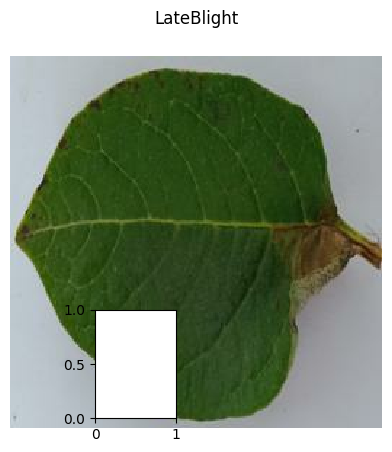

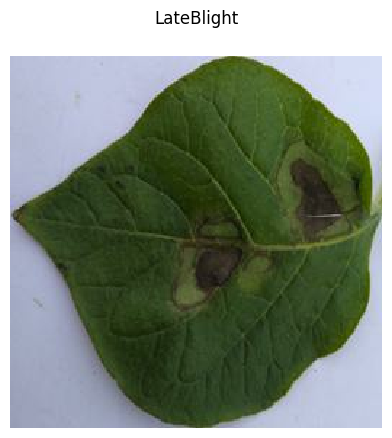

In [12]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        ax=plt.subplot(3,4,i+1)
        plt.matshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
for i in dataset.take(1):
    print(i[0].numpy().shape)

(32, 256, 256, 3)


In [14]:
len(dataset)

128

In [17]:
train_size=0.8
len(dataset)*train_size

102.4

In [18]:
train_ds=dataset.take(102)

In [19]:
len(train_ds)

102

In [20]:
test_ds=dataset.skip(102)

In [21]:
len(test_ds)

26

In [29]:
validation_size=0.1
round(len(test_ds)*validation_size)

3

In [23]:
validation_dataset=test_ds.take(3)
test_dataset=test_ds.skip(3)

In [24]:
len(test_dataset)

23

In [41]:
def get_data_partition(df,train_split=0.8,validation_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

    df_size=len(df)
    if shuffle:
        ds=df.shuffle(shuffle_size,seed=12)
    train_ds=df.take(round(((df_size))*train_split))
    validation_ds=df.take(round((df_size)*validation_split))
    test_ds=df.take(round((df_size)*test_split))

    return (train_ds),(test_ds),(validation_ds)

In [42]:
get_data_partition(df=dataset)

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [43]:
train_ds,test_ds,validation_ds=get_data_partition(df=dataset)

In [44]:
len(train_ds)

102

In [45]:
len(test_ds)

13

In [46]:
len(validation_ds)

13

In [47]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds=validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [59]:
resize_and_rescale=tf.keras.Sequential([
    keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.Rescaling(1.0/255),
])

In [62]:
data_augmenatation=tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal and vertical"),
    keras.layers.RandomRotation(0.2)
])